# Compare supervised and unsupervised methods of determining metapath importance

This notebook evaluates how well the sum of negative logs of metapath p_values agrees with the supervised rankings found in Rephetio. Our dataset of choice is the set of compounds connected to epilepsy with length 3 or less metapaths

In [1]:
import math

from matplotlib import pyplot as plt
import pandas
import plotnine as p9
import scipy
from scipy import stats
from tqdm.notebook import tqdm

from src.database_utils import get_db_connection

In [2]:
epilepsy_id = 'DOID:1826'

supervised_predictions_df = pandas.read_csv('https://raw.githubusercontent.com/dhimmel/learn/b2460a1ecdec1078d673634688784f3eb5e3fc43/prediction/predictions/probabilities.tsv', sep='\t')

In [3]:
query_template = '''\
SELECT
  dwpc,
  p_value,
  metapath_id,
  source_node.name AS source_name, 
  target_node.name AS target_name,
  source_node.identifier AS source_identifier 
FROM dj_hetmech_app_pathcount pc 
JOIN dj_hetmech_app_node source_node 
   ON pc.source_id = source_node.id 
JOIN dj_hetmech_app_node target_node 
   ON pc.target_id = target_node.id     
WHERE (target_node.identifier='{disease_id}' AND source_node.metanode_id='Compound')
  OR (source_node.identifier='{disease_id}' AND target_node.metanode_id='Compound')
ORDER BY pc.p_value
'''

def construct_disease_query(disease_id):
    # If this query is used for different node types, it may be necessary to add an additional condition
    # that the matching node is of the correct type e.g. Disease
    return query_template.format(disease_id=disease_id)

def get_disease_df(disease_id, supervised_predictions_df):
    # Get the unsupervised compound information for a given disease
    query = construct_disease_query(disease_id)
    with get_db_connection() as connection:
        metapaths = pandas.read_sql(query, connection)

    # If the source node is a disease instead of a compound, swap it with the target node
    reversed_indices = metapaths['source_identifier'] == disease_id
    metapaths['temp'] = metapaths['source_name']
    metapaths.loc[reversed_indices, 'source_name'] = metapaths['target_name']
    metapaths.loc[reversed_indices, 'target_name'] = metapaths['temp']

    metapaths.drop(['temp', 'source_identifier'], axis=1)
    
    metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])
    # Ensure that you only have one copy of each (source_name, metapath_id) pair
    metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])
    # Remove any rows with NaN values
    metapaths = metapaths.dropna()
    min_p_value = metapaths[metapaths.p_value != 0].p_value.min()
    # Replace zero p-values to keep the log conversion from breaking
    metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value
    metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

    max_column = metapaths.groupby('source_name')['neg_log_p_value'].max()
    mean_column = metapaths.groupby('source_name')['neg_log_p_value'].mean()

    neg_log_sum = metapaths.groupby('source_name').sum()
    neg_log_sum = neg_log_sum.sort_values(by='neg_log_p_value', ascending=False)
    # TODO drop dwpc and p_value
    neg_log_sum['max_neg_log'] = max_column
    neg_log_sum['mean_neg_log'] = mean_column
    neg_log_sum['max_percent_of_total'] = 100 * (neg_log_sum['max_neg_log'] / neg_log_sum['neg_log_p_value'])

    disease_predictions_df = supervised_predictions_df[supervised_predictions_df.disease_id == disease_id]
    # Remove predictions on drugs not in the other dataframe
    disease_predictions_df = disease_predictions_df[disease_predictions_df.compound_name.isin(neg_log_sum.index)]
    disease_predictions_df = disease_predictions_df.sort_values(by='disease_percentile', ascending=False)

    # Get the unsupervised compound ranking
    neg_log_sum = neg_log_sum.reset_index()
    neg_log_sum['unsupervised_rank'] = neg_log_sum.index

    # Sort neg_log_sum matching names in disease_predicitons_df 
    combined_df = neg_log_sum.merge(disease_predictions_df, how="left", right_on='compound_name', left_on='source_name')

    combined_df = combined_df.sort_values(by='disease_percentile', ascending=False).reset_index(drop=True)
    combined_df['supervised_rank'] = combined_df.index.copy()

    return combined_df

In [4]:
%%time
epilepsy_df = get_disease_df(epilepsy_id, supervised_predictions_df)
epilepsy_df.head(2)

CPU times: user 187 ms, sys: 5.14 ms, total: 192 ms
Wall time: 1.31 s


,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank
0,Topiramate,98.124329,11.629215,51.284526,9.338520,1.465272,18.209236,0,DB00273,Topiramate,...,1,0.1013,0.602683,0.944218,1.0,1.00000,NaN,NaN,NaN,0
1,Ethotoin,69.322580,9.536655,41.040104,11.163887,1.415176,27.202385,13,DB00754,Ethotoin,...,0,0.0000,0.588531,NaN,1.0,0.99935,0.0,0.0,1.0,1


Text(0, 0.5, 'Unsupervised drug rank')

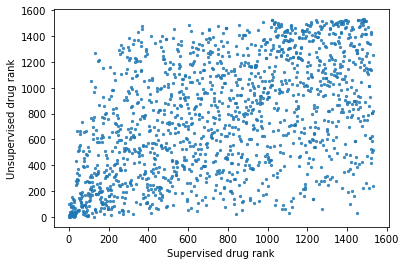

In [5]:
plt.scatter(epilepsy_df['supervised_rank'], epilepsy_df['unsupervised_rank'], alpha=.8, s=5)
plt.xlabel('Supervised drug rank')
plt.ylabel('Unsupervised drug rank')

In [6]:
scipy.stats.kendalltau(epilepsy_df.index, epilepsy_df['unsupervised_rank'])

KendalltauResult(correlation=0.3456149225311213, pvalue=2.141103224642258e-91)

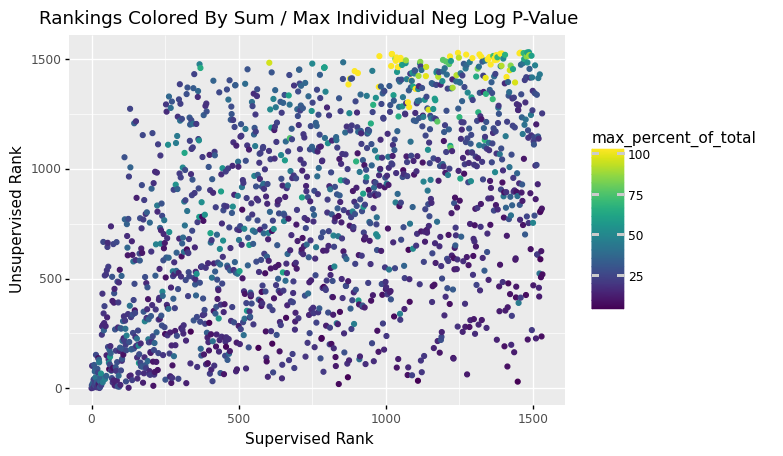

<ggplot: (8759126187620)>

In [7]:
(
    p9.ggplot(epilepsy_df, p9.aes('supervised_rank', 'unsupervised_rank', color='max_percent_of_total')) 
    + p9.geom_point()
    + p9.labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
    + p9.ggtitle('Rankings Colored By Sum / Max Individual Neg Log P-Value')
)

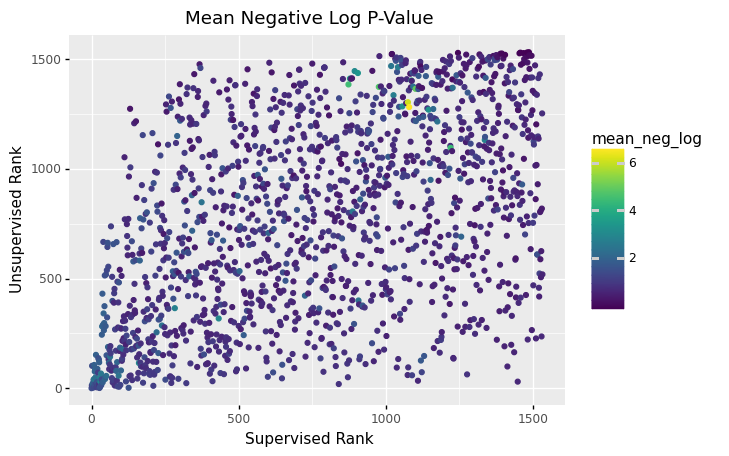

<ggplot: (8759126142675)>

In [8]:
(
    p9.ggplot(epilepsy_df, p9.aes('supervised_rank', 'unsupervised_rank', color='mean_neg_log')) 
    + p9.geom_point()
    + p9.labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
    + p9.ggtitle('Mean Negative Log P-Value')
)

In [9]:
epilepsy_df['status_drugcentral'] = epilepsy_df['status_drugcentral'].astype('category')
epilepsy_df[epilepsy_df['status_drugcentral'] == 1]

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank
1,Ethotoin,69.322580,9.536655,41.040104,11.163887,1.415176,27.202385,13,DB00754,Ethotoin,...,0,0.00000,0.588531,NaN,1.000000,0.999350,0.0,0.0,1.0,1
5,Lorazepam,64.965338,2.592023,44.664731,16.152869,2.126892,36.164708,5,DB00186,Lorazepam,...,0,0.00000,0.488540,NaN,1.000000,0.996749,11.0,1.0,1.0,5
8,Methsuximide,47.001929,0.528717,33.458294,8.429114,2.573715,25.192899,41,DB05246,Methsuximide,...,0,0.00000,0.434328,NaN,1.000000,0.994798,0.0,0.0,1.0,8
29,Pentobarbital,70.727452,8.068361,43.692659,13.585391,1.618247,31.093074,6,DB00312,Pentobarbital,...,0,0.00000,0.146912,NaN,1.000000,0.981144,1.0,1.0,1.0,29
31,Secobarbital,40.252952,1.459940,35.913764,14.509167,2.992814,40.400018,29,DB00418,Secobarbital,...,0,0.00000,0.131900,NaN,1.000000,0.979844,0.0,0.0,1.0,31
36,Methylphenobarbital,36.104317,1.108301,21.635027,3.836522,2.163503,17.732921,282,DB00849,Methylphenobarbital,...,0,0.00000,0.114096,NaN,1.000000,0.976593,0.0,0.0,1.0,36
38,Nitrazepam,44.423277,5.158575,36.589958,16.504204,1.925787,45.105831,27,DB01595,Nitrazepam,...,0,0.00000,0.104291,NaN,1.000000,0.975293,0.0,0.0,1.0,38
44,Thiopental,33.908347,1.811478,19.482307,4.877034,1.771119,25.033145,374,DB00599,Thiopental,...,0,0.00000,0.098679,NaN,1.000000,0.971391,1.0,1.0,1.0,44
61,Ethosuximide,34.694466,7.598993,24.777963,8.991578,1.179903,36.288610,175,DB00593,Ethosuximide,...,0,0.00000,0.072529,NaN,1.000000,0.960338,1.0,1.0,1.0,61
73,Phensuximide,61.307278,10.001541,28.040174,3.039454,1.001435,10.839639,93,DB00832,Phensuximide,...,0,0.00000,0.048725,NaN,1.000000,0.952536,0.0,0.0,1.0,73


/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


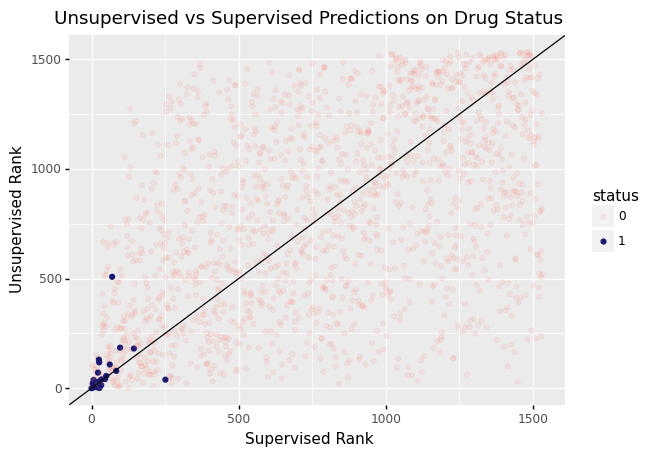

<ggplot: (8759296854218)>

In [10]:
epilepsy_df['status'] = epilepsy_df['status'].astype('category')
(
    p9.ggplot(epilepsy_df, p9.aes('supervised_rank', 'unsupervised_rank', color='status', alpha='status')) 
    + p9.geom_point()
    + p9.labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
    + p9.geom_abline(intercept=0, slope=1)
    + p9.scale_color_manual(['salmon', 'midnightblue'])
    + p9.ggtitle('Unsupervised vs Supervised Predictions on Drug Status')
)

In [11]:
# Find the items with the biggest difference between the unsupervised and supervised ranks
epilepsy_df['rank_difference'] = epilepsy_df['unsupervised_rank'] - epilepsy_df['supervised_rank']
epilepsy_df = epilepsy_df.sort_values(by='rank_difference', ascending=True)
epilepsy_df.head()

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
1448,Betamethasone,149.228431,18.065031,35.050099,2.380723,0.730210,6.792344,30,DB00443,Betamethasone,...,0.34920,0.000968,0.031303,0.661765,0.055267,0.0,0.0,0.0,1448,-1418
1413,Triamcinolone,101.417354,18.065371,27.651593,2.939707,0.691290,10.631240,99,DB00620,Triamcinolone,...,0.37720,0.001081,0.037798,0.713235,0.078023,NaN,NaN,NaN,1413,-1314
1529,Azacitidine,95.634809,10.949981,22.626537,2.240725,0.754218,9.903084,236,DB00928,Azacitidine,...,0.00000,0.000519,NaN,0.154412,0.002601,0.0,0.0,0.0,1529,-1293
1510,Isotretinoin,88.174783,13.976466,22.878114,3.593193,0.693276,15.705811,227,DB00982,Isotretinoin,...,0.03379,0.000676,0.003311,0.264706,0.014954,0.0,0.0,0.0,1510,-1283
1436,Methylprednisolone,90.244569,15.911498,25.218101,3.546533,0.681570,14.063441,164,DB00959,Methylprednisolone,...,0.32150,0.001013,0.030082,0.757353,0.063069,4.0,1.0,0.0,1436,-1272


In [12]:
epilepsy_df.tail()

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
349,Oxaliplatin,15.113290,3.531222,3.444684,0.872139,0.430586,25.318406,1432,DB00526,Oxaliplatin,...,0.0,0.007352,NaN,0.860294,0.773082,0.0,0.0,0.0,349,1083
300,Apixaban,14.386028,3.540274,4.413468,1.085432,0.490385,24.593622,1386,DB06605,Apixaban,...,0.0,0.008667,NaN,0.985294,0.804941,0.0,0.0,0.0,300,1086
370,Oritavancin,7.262815,0.127016,2.693650,1.728382,1.346825,64.165072,1460,DB04911,Oritavancin,...,0.0,0.006958,NaN,0.985294,0.759428,0.0,0.0,0.0,370,1090
367,Malathion,5.151089,2.555319,2.225061,1.040573,0.445012,46.766065,1477,DB00772,Malathion,...,0.0,0.007003,NaN,0.992647,0.761378,0.0,0.0,0.0,367,1110
131,Piroxicam,32.121209,10.399281,6.469555,1.663666,0.359420,25.715302,1274,DB00554,Piroxicam,...,0.0,0.019792,NaN,0.985294,0.914824,0.0,0.0,0.0,131,1143


In [13]:
epilepsy_df[epilepsy_df['source_name'] == 'Cisplatin']

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
297,Cisplatin,33.699095,7.558449,5.72067,1.48347,0.408619,25.931757,1317,DB00515,Cisplatin,...,0.262,0.008713,0.179898,0.742647,0.806892,0.0,0.0,0.0,297,1020


In [14]:
epilepsy_df[epilepsy_df['source_name'] == 'Betamethasone']

,source_name,dwpc,p_value,neg_log_p_value,max_neg_log,mean_neg_log,max_percent_of_total,unsupervised_rank,compound_id,compound_name,...,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,supervised_rank,rank_difference
1448,Betamethasone,149.228431,18.065031,35.050099,2.380723,0.73021,6.792344,30,DB00443,Betamethasone,...,0.3492,0.000968,0.031303,0.661765,0.055267,0.0,0.0,0.0,1448,-1418


# Test another disease
Let's see if the good performance we saw on epilepsy holds on less studied diseases like Barrett's esophagus.

In [15]:
barretts_id = 'DOID:9206'
barretts_df = get_disease_df(barretts_id, supervised_predictions_df)

/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/scales/scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


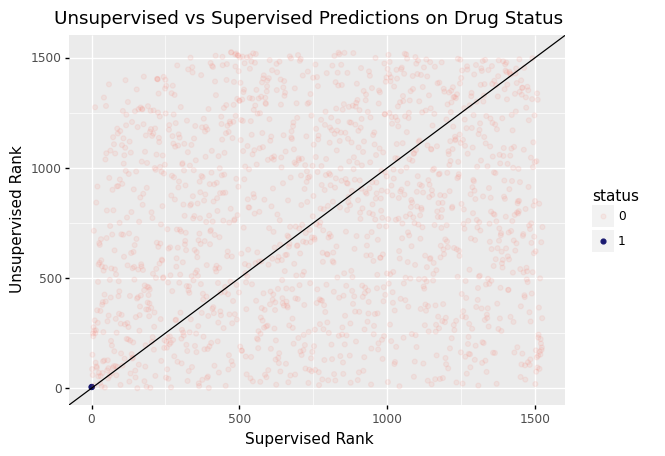

<ggplot: (8759126254553)>

In [16]:
barretts_df['status'] = barretts_df['status'].astype('category')

(
    p9.ggplot(barretts_df, p9.aes('supervised_rank', 'unsupervised_rank', color='status', alpha='status')) 
    + p9.geom_point()
    + p9.labs(x = 'Supervised Rank', y = 'Unsupervised Rank')
    + p9.geom_abline(intercept=0, slope=1)
    + p9.scale_color_manual(['salmon', 'midnightblue'])
    + p9.ggtitle('Unsupervised vs Supervised Predictions on Drug Status')
)

# All Diseases
Since the unsupervised prediction worked well for Barett's esophagus, let's see how well it works on all diseases

In [17]:
# Get unsupervised rankings and merge them with the supervised to get status
# Add the unsupervised and supervised ranks of all compounds with status=1 to lists
# plot histograms
disease_ids = supervised_predictions_df['disease_id'].unique()
supervised_ranks = []
unsupervised_ranks = []
for disease_id in tqdm(disease_ids):
    disease_df = get_disease_df(disease_id, supervised_predictions_df)
    supervised_ranks.append(disease_df[disease_df['status'] == 1]['supervised_rank'])
    unsupervised_ranks.append(disease_df[disease_df['status'] == 1]['unsupervised_rank'])
unsupervised_ranks = unsupervised_ranks[0].append(unsupervised_ranks[1:], ignore_index=True)
supervised_ranks = supervised_ranks[0].append(supervised_ranks[1:], ignore_index=True)

  0%|          | 0/136 [00:00<?, ?it/s]

In [18]:
rank_df = pandas.DataFrame({'Unsupervised': unsupervised_ranks, 'Supervised': supervised_ranks})
melted_df = rank_df.melt()
melted_df.columns = ['Ranking Method', 'Rank']

In [19]:
melted_df.head()

,Ranking Method,Rank
0,Unsupervised,60
1,Unsupervised,161
2,Unsupervised,460
3,Unsupervised,295
4,Unsupervised,5


/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 94'. Pick better value with 'binwidth'.


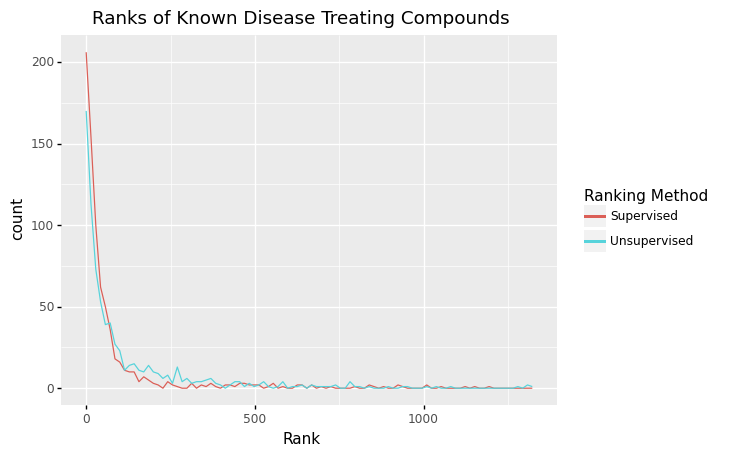

<ggplot: (8759125906839)>

In [20]:
(
    p9.ggplot(melted_df, p9.aes('Rank', color='Ranking Method'))
    + p9.geom_freqpoly()
    + p9.ggtitle('Ranks of Known Disease Treating Compounds')
)

/home/dhimmel/miniconda3/envs/hetmech/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 94'. Pick better value with 'binwidth'.


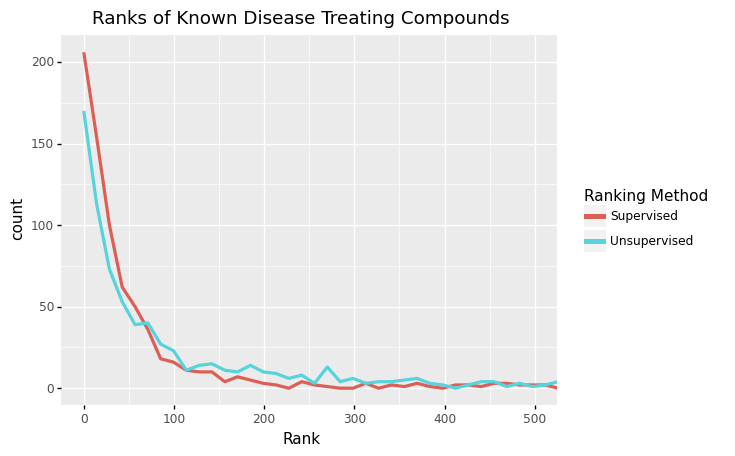

<ggplot: (8759125906881)>

In [21]:
(
    p9.ggplot(melted_df, p9.aes('Rank', color='Ranking Method'))
    + p9.geom_freqpoly(size=1.3)
    + p9.coord_cartesian([0, 500]) 
    + p9.ggtitle('Ranks of Known Disease Treating Compounds')
)